In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [6]:
BASE_DIR = '/home/nayan/ml/brain_tumor_classification/data/'
MULTICLASS_DIR = '/home/nayan/ml/brain_tumor_classification/data/raw/multiclass'
PROCESSED_DIR = '/home/nayan/ml/brain_tumor_classification/data/processed/'
MODELS_DIR = '/home/nayan/ml/brain_tumor_classification/models'
RESULTS_DIR = '/home/nayan/ml/brain_tumor_classification/results'

for dir_path in [PROCESSED_DIR, MODELS_DIR, RESULTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Image configuration
IMG_SIZE = 128  # Resize all images to 128x128
IMG_CHANNELS = 3  # RGB (we'll convert grayscale to RGB for consistency)

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print("Configuration:")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Train/Val/Test Split: {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")
print(f"  Dataset Directory: {MULTICLASS_DIR}")
print(f"  Output Directory: {PROCESSED_DIR}")

Configuration:
  Image Size: 128x128
  Train/Val/Test Split: 0.7/0.15/0.15
  Dataset Directory: /home/nayan/ml/brain_tumor_classification/data/raw/multiclass
  Output Directory: /home/nayan/ml/brain_tumor_classification/data/processed/


In [8]:
def load_and_preprocess_image(image_path, target_size = (128,128)):
    try:
        img = Image.open(image_path)

        if img.mode != 'RGB':
            img = Image.convert('RGB')
            
        img = Image.resize(target_size, Image.LANCZOS)
        img_array = np.array(img)
        img_array = img_array.astype('float32') / 255.0
        return img_array
    
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None
def get_image_paths_with_labels(base_dir):

    image_paths = []
    labels = []
    
    # Get class folders
    class_folders = [d for d in os.listdir(base_dir) 
                     if os.path.isdir(os.path.join(base_dir, d))]
    
    print(f"\nFound {len(class_folders)} classes: {class_folders}")
    
    for class_name in class_folders:
        class_path = os.path.join(base_dir, class_name)
        
        # Get all image files
        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, file))
                labels.append(class_name)
    
    return image_paths, labels

LOADING DATASET

Found 4 classes: ['glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'normal']

Total images found: 3096
Total labels: 3096

Class Distribution:
label
meningioma_tumor    913
glioma_tumor        901
pituitary_tumor     844
normal              438
Name: count, dtype: int64


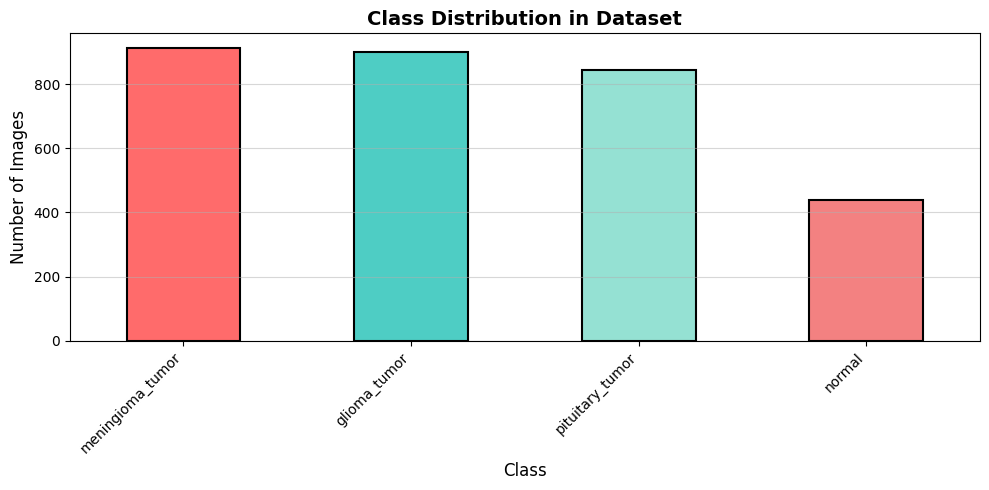

Image saved as 'class_distribution_preprocessing.png' in  /home/nayan/ml/brain_tumor_classification/results


In [10]:
print("=" * 80)
print("LOADING DATASET")
print("=" * 80)

# Get all image paths and labels
image_paths, labels = get_image_paths_with_labels(MULTICLASS_DIR)

print(f"\nTotal images found: {len(image_paths)}")
print(f"Total labels: {len(labels)}")

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Display class distribution
print("\nClass Distribution:")
class_counts = df['label'].value_counts()
print(class_counts)

# Visualize
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181'], 
                  edgecolor='black', linewidth=1.5)
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'figures', 'class_distribution_preprocessing.png'), 
            dpi=300, bbox_inches='tight')
plt.show()
print("Image saved as 'class_distribution_preprocessing.png' in ", RESULTS_DIR)

In [13]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("\nLabel Encoding Mapping:")
label_mapping = {
    cls: int(idx)
    for cls, idx in zip(
        label_encoder.classes_,
        label_encoder.transform(label_encoder.classes_)
    )
}

for original, encoded in label_mapping.items():
    print(f"  {original} → {encoded}")

# Save label encoder for future use
with open(os.path.join(MODELS_DIR, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

# Save mapping as JSON for easy reference
with open(os.path.join(MODELS_DIR, 'label_mapping.json'), 'w') as f:
    json.dump(label_mapping, f, indent=4)


Label Encoding Mapping:
  glioma_tumor → 0
  meningioma_tumor → 1
  normal → 2
  pituitary_tumor → 3
